In [1]:
import numpy as np
from utils import plot_protein
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

KERNEL_RADIUS = 3
NUM_MOLECULES = 2

Using device cuda


In [95]:
directions_to_offsets = np.array([
    # Only cardinal directions
    [ 0,  0, -1],
    [ 0,  0,  1],
    [ 0, -1,  0],
    [ 0,  1,  0],
    [-1,  0,  0],
    [ 1,  0,  0],
    # All 26 directions
    [-1, -1, -1],
    [-1,  0, -1],
    [-1,  1, -1],
    [ 0, -1, -1],
    [ 0,  1, -1],
    [ 1, -1, -1],
    [ 1,  0, -1],
    [ 1,  1, -1],
    [-1, -1,  0],
    [-1,  1,  0],
    [ 1, -1,  0],
    [ 1,  1,  0],
    [-1, -1,  1],
    [-1,  0,  1],
    [-1,  1,  1],
    [ 0, -1,  1],
    [ 0,  1,  1],
    [ 1, -1,  1],
    [ 1,  0,  1],
    [ 1,  1,  1]
])
NUM_DIRECTIONS = directions_to_offsets.shape[0]

def build_proteins(sequence, directions):
    # Make sure the directions have the correct length
    assert directions.shape[1] == len(sequence) - 1, f"dimension 1 ({directions.shape[1]}) of directions must be 1 less than length of sequences ({len(sequence)})"
    proteins = np.zeros((directions.shape[0], len(sequence), 3), dtype=int)
    # The first pos is always 0,0,0. Walk along the protein and build it
    for i in range(1, len(sequence)):
        proteins[:, i] = proteins[:, i-1] + directions_to_offsets[directions[:, i-1]]
    # Shift the proteins, so all coordinates are nonnegative.
    min_coords = np.min(proteins, axis=1, keepdims=True)  # Shape (batch, 1, 3)
    assert min_coords.shape == (directions.shape[0], 1, 3), f"Batch size is {directions.shape[0]}, resulting shape is {min_coords.shape}"
    proteins -= min_coords
    # Shift by the padding, to make slicing easier.
    proteins += KERNEL_RADIUS
    
    return proteins

#sequence = np.random.randint(0, NUM_MOLECULES, size=(100))
sequence = np.concatenate([np.full((5), 0), np.full((20), 1), np.full((5), 0), np.full((20), 1), np.full((5), 0)])
print(sequence)

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


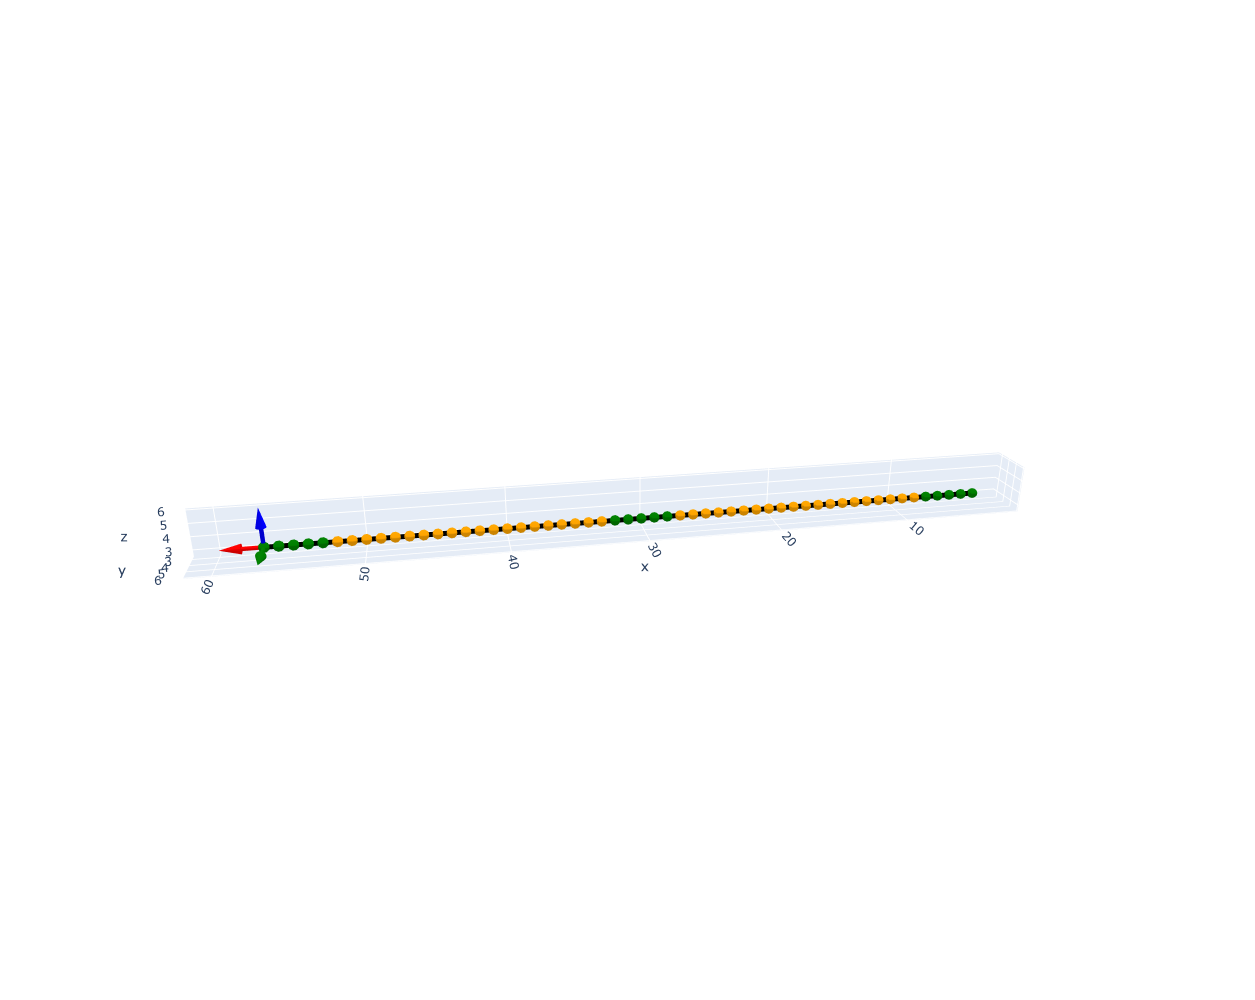

In [102]:
straight_coords = build_proteins(sequence, np.full((1, sequence.shape[0] - 1), 5))
plot_protein(sequence, straight_coords[0], current_pos=straight_coords[0, -1], current_orientation=np.eye(3))

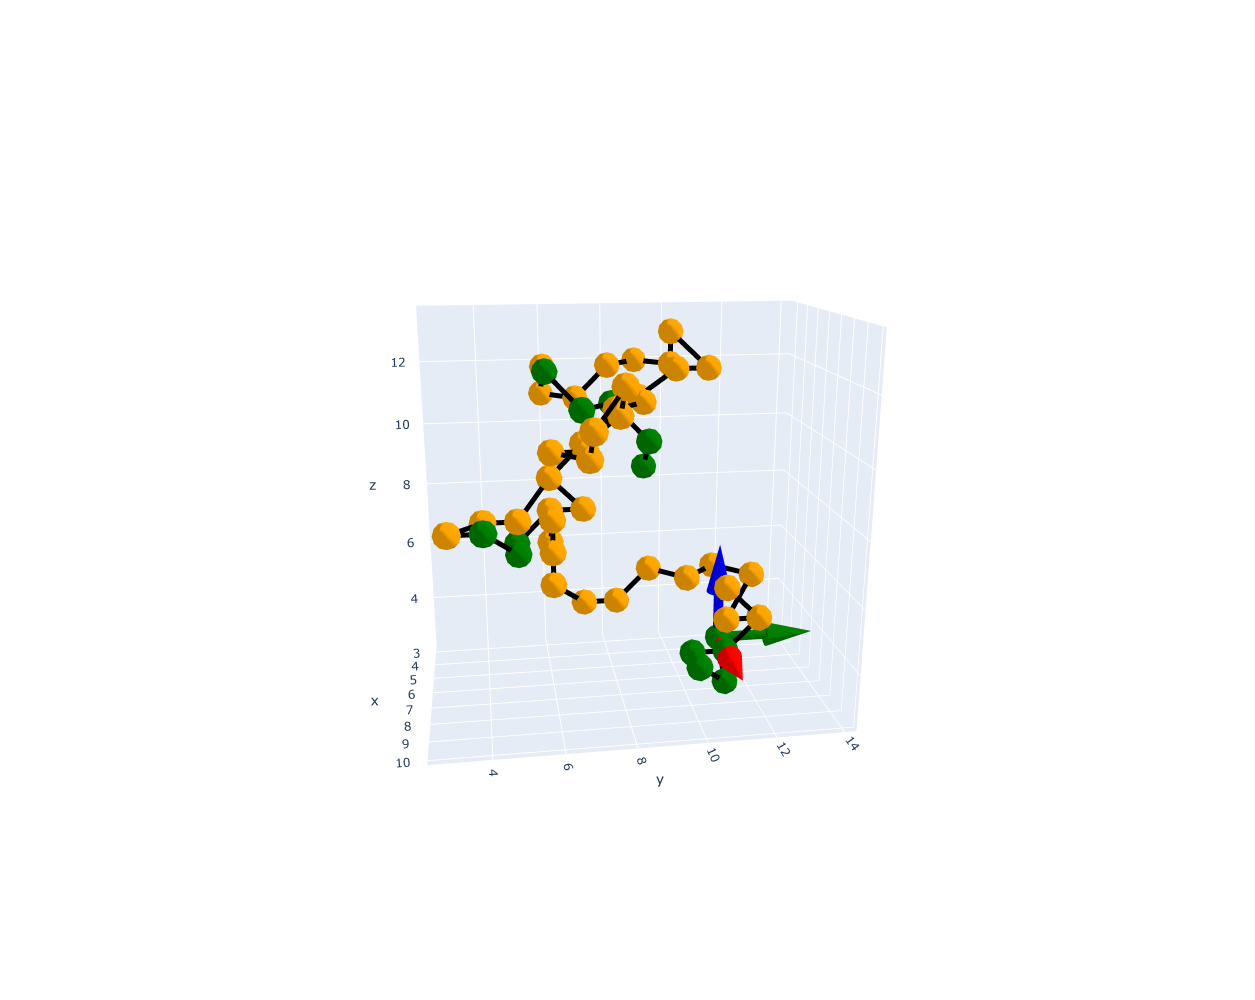

In [100]:
rand_coords = build_proteins(sequence, np.random.randint(0, 26, (1, sequence.shape[0] - 1)))
plot_protein(sequence, rand_coords[0], current_pos=rand_coords[0, -1], current_orientation=np.eye(3))

In [5]:
# Converts the coordinates to a bool tensor of shape (batch, NUM_MOLECULES, x, y, z)
def voxelize(sequence, coords):

    max_coords = np.max(coords, axis=(0, 1), keepdims=False)  # Shape: (3)
    volume = torch.zeros((coords.shape[0], NUM_MOLECULES, *max_coords + KERNEL_RADIUS + 1), device=device, dtype=torch.int8)
    # Iterate over the sequence and fill the volume.
    for i, molecule in enumerate(sequence):
        batch_positions = coords[:, i, :]
        volume[:, molecule, batch_positions[:, 0], batch_positions[:, 1], batch_positions[:, 2]] = 1
    
    return volume

In [6]:
def stack_volumes(coords, volume):

    coords = torch.tensor(coords, dtype=torch.long, device=device)
    batch_size, protein_length, _ = coords.shape
    D, H, W = volume.shape[2], volume.shape[3], volume.shape[4]
    neighborhood_size = 2 * KERNEL_RADIUS + 1

    # Generate Neighborhood Offsets
    offsets = torch.arange(-KERNEL_RADIUS, KERNEL_RADIUS + 1, device=device)
    offsets_z, offsets_y, offsets_x = torch.meshgrid(offsets, offsets, offsets, indexing='ij')
    offsets = torch.stack((offsets_x, offsets_y, offsets_z), dim=-1)
    offsets = offsets.view(-1, 3)

    # Calculate Absolute Positions
    batch_positions = coords.long().unsqueeze(2)
    neighborhood_positions = batch_positions + offsets

    # Convert to Linear Indices
    x_indices = neighborhood_positions[..., 0]
    y_indices = neighborhood_positions[..., 1]
    z_indices = neighborhood_positions[..., 2]
    linear_indices = x_indices * (H * W) + y_indices * W + z_indices
    linear_indices = linear_indices.view(batch_size, -1)

    # Flatten the Volume Tensor
    volume_flat = volume.view(batch_size, NUM_MOLECULES, -1)
    volume_flat_t = volume_flat.permute(0, 2, 1)

    # Extract Neighborhoods
    expanded_indices = linear_indices.unsqueeze(-1).expand(-1, -1, NUM_MOLECULES)
    gathered = torch.gather(volume_flat_t, 1, expanded_indices)

    # Reshape the Gathered Values
    gathered = gathered.view(batch_size, protein_length, neighborhood_size, neighborhood_size, neighborhood_size, NUM_MOLECULES)
    neighborhoods = gathered.permute(0, 1, 5, 2, 3, 4)
    return neighborhoods

In [90]:
like_molecule_kernel = torch.ones((2*KERNEL_RADIUS+1, 2*KERNEL_RADIUS+1, 2*KERNEL_RADIUS+1), dtype=torch.float32, device=device)
like_molecule_kernel[KERNEL_RADIUS, KERNEL_RADIUS] = 0
dislike_molecule_kernel = -torch.ones((2*KERNEL_RADIUS+1, 2*KERNEL_RADIUS+1, 2*KERNEL_RADIUS+1), dtype=torch.float32, device=device)
dislike_molecule_kernel[KERNEL_RADIUS, KERNEL_RADIUS] = 0

first_molecule_kernel = torch.stack([5 * like_molecule_kernel, dislike_molecule_kernel])
second_molecule_kernel = torch.stack([dislike_molecule_kernel, dislike_molecule_kernel])
kernels = [first_molecule_kernel, second_molecule_kernel]

def calculate_affinity(sequence, stacked):
    affinity = torch.zeros((stacked.shape[0]), dtype=torch.float32, device=device)
    for i, molecule in enumerate(sequence):
        kernel = kernels[molecule][None, ...] # Add a batch dimension
        neighborhoods = stacked[:, i, ...]
        affinity += (neighborhoods * kernel).sum(dim=(1, 2, 3, 4))

    return affinity

In [9]:
def fitness_func(ga_instance, solutions, solution_indces):
    coords = build_proteins(sequence, solutions)
    volume = voxelize(sequence, coords)
    stacked = stack_volumes(coords, volume)
    fitness = calculate_affinity(sequence, stacked)
    return fitness.cpu().numpy()

# Random directions:
#print(fitness_func(None, np.random.randint(0, 26, (1, sequence.shape[0]-1)), None))
# Straight snake:
#print(fitness_func(None, np.full((1, sequence.shape[0]-1), 4), None))

In [91]:
import pygad

def on_gen(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}, best fitness: {ga_instance.best_solution()[1]}")

ga_instance = pygad.GA(num_generations=100,
                       num_parents_mating=1000,
                       fitness_func=fitness_func,
                       sol_per_pop=2000,
                       gene_type=int,
                       num_genes=sequence.shape[0] - 1,
                       init_range_low=0,
                       init_range_high=NUM_DIRECTIONS,
                       fitness_batch_size=1000,
                       on_generation=on_gen)

ga_instance.run()

Generation: 1, best fitness: 2238.0
Generation: 2, best fitness: 2795.0
Generation: 3, best fitness: 4842.0
Generation: 4, best fitness: 4842.0
Generation: 5, best fitness: 4842.0
Generation: 6, best fitness: 4842.0
Generation: 7, best fitness: 5111.0
Generation: 8, best fitness: 5111.0
Generation: 9, best fitness: 5111.0
Generation: 10, best fitness: 5111.0
Generation: 11, best fitness: 5111.0
Generation: 12, best fitness: 5291.0
Generation: 13, best fitness: 5793.0
Generation: 14, best fitness: 5793.0
Generation: 15, best fitness: 5793.0
Generation: 16, best fitness: 6372.0
Generation: 17, best fitness: 6372.0
Generation: 18, best fitness: 6372.0
Generation: 19, best fitness: 6744.0
Generation: 20, best fitness: 6744.0
Generation: 21, best fitness: 6744.0
Generation: 22, best fitness: 6744.0
Generation: 23, best fitness: 6744.0
Generation: 24, best fitness: 6744.0
Generation: 25, best fitness: 6744.0
Generation: 26, best fitness: 6744.0
Generation: 27, best fitness: 6744.0
Generation

11587.0


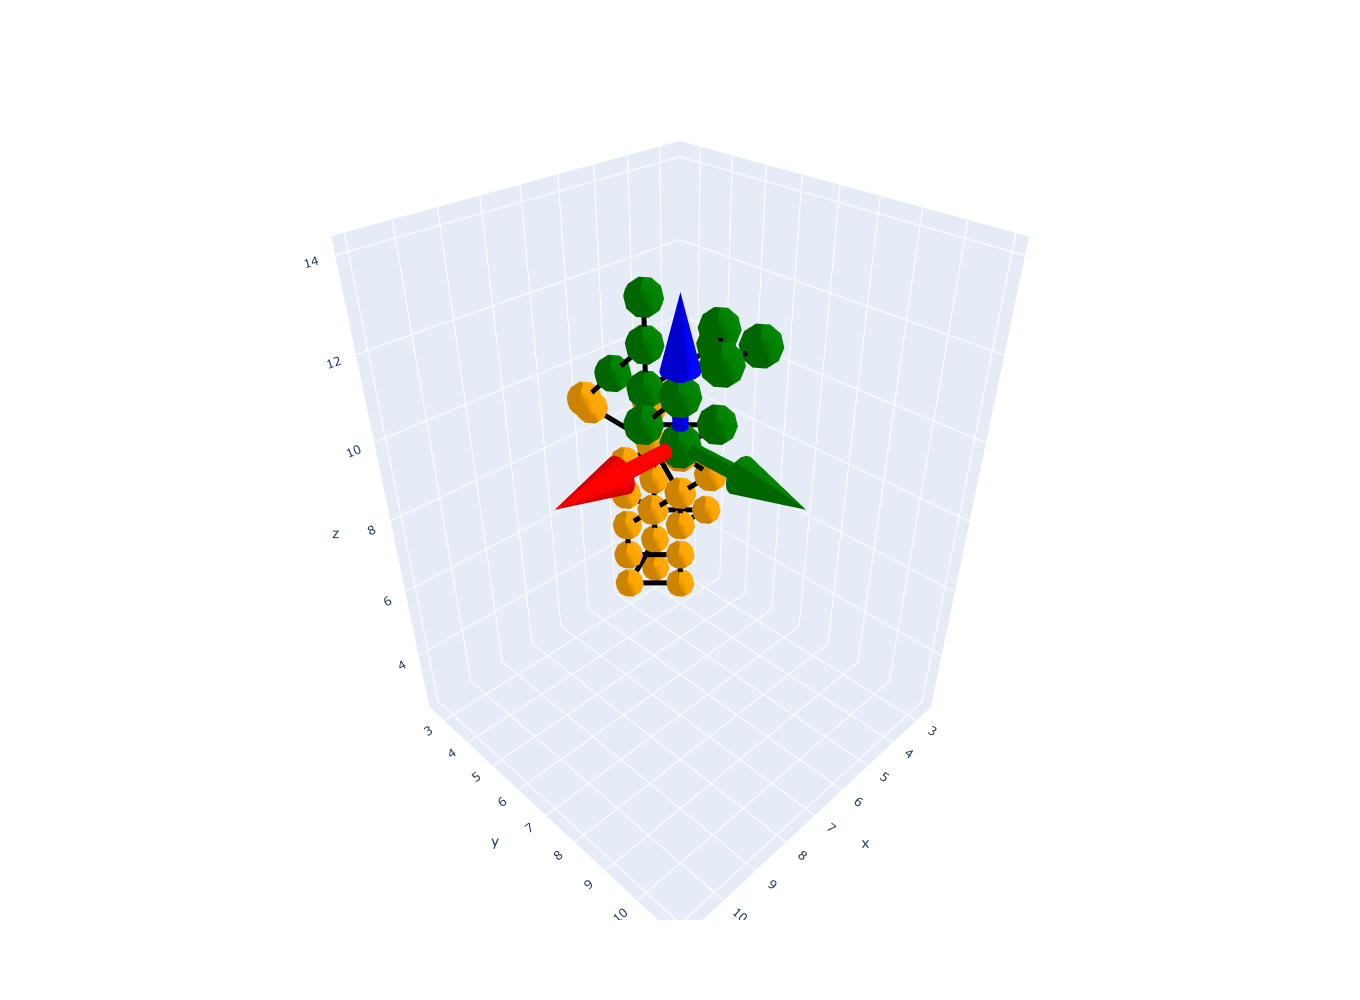

In [92]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution_fitness)
coords = build_proteins(sequence, solution[None, ...])
plot_protein(sequence, coords[0], current_pos=coords[0, -1], current_orientation=np.eye(3))

In [101]:
# Some not used stuff with rotation matrices
# Can be used to use local rotations instead of global directions.

def rotation_z(angle_degrees):
    # Convert degrees to radians
    theta = np.radians(angle_degrees)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [ c, -s, 0],
        [ s,  c, 0],
        [ 0,  0, 1]
    ])

def rotation_x(angle_degrees):
    theta = np.radians(angle_degrees)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [1, 0,  0],
        [0, c, -s],
        [0, s,  c]
    ])

def rotation_y(angle_degrees):
    theta = np.radians(angle_degrees)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [ c, 0, s],
        [ 0, 1, 0],
        [-s, 0, c]
    ])

orientation = np.eye(3)
print(f"forward {orientation[:, 1]}")
print(f"up      {orientation[:, 2]}")

orientation = np.round(orientation @ rotation_z(-90))
print(f"forward {orientation[:, 1]}")
print(f"up      {orientation[:, 2]}")

orientation = np.round(orientation @ rotation_x(90))
print(f"forward {orientation[:, 1]}")
print(f"up      {orientation[:, 2]}")

forward [0. 1. 0.]
up      [0. 0. 1.]
forward [1. 0. 0.]
up      [0. 0. 1.]
forward [0. 0. 1.]
up      [-1.  0.  0.]


In [14]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import pandas as pd


base_url = "https://raw.githubusercontent.com/plotly/datasets/master/ply/"
mesh_names = ['sandal', 'scissors', 'shark', 'walkman']
dataframes = {
    name: pd.read_csv(base_url + name + '-ply.csv') 
    for name in mesh_names
}

app = Dash(__name__)

app.layout = html.Div([
    html.H4('PLY Object Explorer'),
    html.P("Choose an object:"),
    dcc.Dropdown(
        id='dropdown',
        options=mesh_names,
        value="sandal",
        clearable=False
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def display_mesh(name):
    df = dataframes[name] # replace with your own data source
    fig = go.Figure(go.Mesh3d(
        x=df.x, y=df.y, z=df.z, 
        i=df.i, j=df.j, k=df.k, 
        facecolor=df.facecolor))
    return fig


app.run_server(debug=True)